### 1- Create an SQL query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features

In [ ]:
# rentals by title
SELECT r.rental_id, r.rental_date, r.inventory_id, r.customer_id 
	, i.film_id, i.store_id
	, f.title, f.rental_duration, f.replacement_cost
	, p.amount
FROM rental r
JOIN inventory i ON r.inventory_id = i.inventory_id
JOIN film f ON i.film_id = f.film_id
JOIN payment p ON r.rental_id = p.rental_id
;

In [110]:
import pymysql
import datetime
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
password = getpass.getpass()

········


### 2- Read the data into a Pandas dataframe

When analyzing data I realized that all the id's are not relevant to our purpose, then I changed the query.

In [4]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'

engine = create_engine(connection_string)

query = '''
        SELECT r.rental_id, r.rental_date, r.inventory_id, r.customer_id 
            , i.film_id, i.store_id
            , f.title, f.rental_duration, f.replacement_cost
            , p.amount
        FROM rental r
        JOIN inventory i ON r.inventory_id = i.inventory_id
        JOIN film f ON i.film_id = f.film_id
        JOIN payment p ON r.rental_id = p.rental_id
        '''

data = pd.read_sql_query(query, engine)
data.head()

,rental_id,rental_date,inventory_id,customer_id,film_id,store_id,title,rental_duration,replacement_cost,amount
0,4863,2005-07-08 19:03:15,1,431,1,1,ACADEMY DINOSAUR,6,20.99,0.99
1,11433,2005-08-02 20:13:10,1,518,1,1,ACADEMY DINOSAUR,6,20.99,3.99
2,14714,2005-08-21 21:27:43,1,279,1,1,ACADEMY DINOSAUR,6,20.99,3.99
3,972,2005-05-30 20:21:07,2,411,1,1,ACADEMY DINOSAUR,6,20.99,1.99
4,2117,2005-06-17 20:24:00,2,170,1,1,ACADEMY DINOSAUR,6,20.99,0.99


In [92]:
query = '''
        SELECT r.rental_id, r.rental_date, r.staff_id
            , f.release_year, f.language_id, f.rental_duration, f.rental_rate, f.length, f.rating, f.special_features
            , i.film_id, i.store_id
            , fc.category_id
        FROM rental r
        JOIN inventory i ON r.inventory_id = i.inventory_id
        JOIN film f ON i.film_id = f.film_id
        JOIN film_category fc ON i.film_id = fc.film_id
        '''

data = pd.read_sql_query(query, engine)
data.head()

,rental_id,rental_date,staff_id,release_year,language_id,rental_duration,rental_rate,length,rating,special_features,film_id,store_id,category_id
0,4863,2005-07-08 19:03:15,2,2006,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1,6
1,11433,2005-08-02 20:13:10,1,2006,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1,6
2,14714,2005-08-21 21:27:43,1,2006,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1,6
3,16050,2021-06-26 13:39:06,1,2006,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1,6
4,972,2005-05-30 20:21:07,1,2006,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1,6


### 3- Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables

In [93]:
data.shape

(16045, 13)

In [94]:
data.dtypes

rental_id                    int64
rental_date         datetime64[ns]
staff_id                     int64
release_year                 int64
language_id                  int64
rental_duration              int64
rental_rate                float64
length                       int64
rating                      object
special_features            object
film_id                      int64
store_id                     int64
category_id                  int64
dtype: object

In [95]:
# checking if rental_id could be the index
data['rental_id'].nunique()

16045

In [96]:
data = data.set_index('rental_id')

In [97]:
data.isna().sum()

rental_date         0
staff_id            0
release_year        0
language_id         0
rental_duration     0
rental_rate         0
length              0
rating              0
special_features    0
film_id             0
store_id            0
category_id         0
dtype: int64

In [98]:
data['staff_id'] = data['staff_id'].astype('object')

In [118]:
data['release_year'].value_counts()

2006    16045
Name: release_year, dtype: int64

In [119]:
data = data.drop('release_year', axis=1)

In [99]:
data['language_id'].value_counts()

1    16045
Name: language_id, dtype: int64

In [100]:
data = data.drop('language_id', axis=1)

In [101]:
# checking to transform into categorical
data['rental_duration'].value_counts()

3    3412
6    3393
4    3251
5    3165
7    2824
Name: rental_duration, dtype: int64

In [102]:
data['rental_duration'] = data['rental_duration'].astype('object')

In [138]:
# checking to transform into categorical
data['rental_rate'].value_counts()

0.99    5653
4.99    5272
2.99    5120
Name: rental_rate, dtype: int64

In [139]:
data['rental_rate'] = data['rental_rate'].astype('object')

In [103]:
data['special_features'].value_counts()

Trailers,Commentaries,Behind the Scenes                   1320
Trailers                                                  1151
Trailers,Commentaries                                     1140
Trailers,Behind the Scenes                                1137
Behind the Scenes                                         1114
Commentaries,Deleted Scenes,Behind the Scenes             1112
Commentaries                                              1101
Commentaries,Behind the Scenes                            1093
Trailers,Deleted Scenes                                   1065
Deleted Scenes,Behind the Scenes                          1050
Deleted Scenes                                            1037
Commentaries,Deleted Scenes                               1020
Trailers,Commentaries,Deleted Scenes,Behind the Scenes    1003
Trailers,Commentaries,Deleted Scenes                       922
Trailers,Deleted Scenes,Behind the Scenes                  780
Name: special_features, dtype: int64

In [104]:
data['store_id'] = data['store_id'].astype('object')

In [105]:
data['category_id'] = data['category_id'].astype('object')

In [145]:
data.dtypes

rental_date         datetime64[ns]
staff_id                    object
rental_duration             object
rental_rate                 object
length                       int64
rating                      object
special_features            object
film_id                      int64
store_id                    object
category_id                 object
year                         int64
month                        int64
key                         object
prev_month                   int64
prev_key                    object
rntd_last_month             object
dtype: object

In [107]:
for col in data.select_dtypes('object'):
    print(data[col].value_counts(), '\n')

1    8041
2    8004
Name: staff_id, dtype: int64 

3    3412
6    3393
4    3251
5    3165
7    2824
Name: rental_duration, dtype: int64 

PG-13    3585
NC-17    3293
PG       3213
R        3181
G        2773
Name: rating, dtype: int64 

Trailers,Commentaries,Behind the Scenes                   1320
Trailers                                                  1151
Trailers,Commentaries                                     1140
Trailers,Behind the Scenes                                1137
Behind the Scenes                                         1114
Commentaries,Deleted Scenes,Behind the Scenes             1112
Commentaries                                              1101
Commentaries,Behind the Scenes                            1093
Trailers,Deleted Scenes                                   1065
Deleted Scenes,Behind the Scenes                          1050
Deleted Scenes                                            1037
Commentaries,Deleted Scenes                               1020
Traile

In [108]:
# Now let's work with Categoricals
data_cat = data.select_dtypes(include = object)
cat_data = pd.get_dummies(data_cat, drop_first=True)
cat_data[:20]

,staff_id_2,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Commentaries,...,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
rental_id,,,,,,,,,,,,,,,,,,,,,
4863,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11433,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14714,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16050,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
972,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2117,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4187,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9449,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15453,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


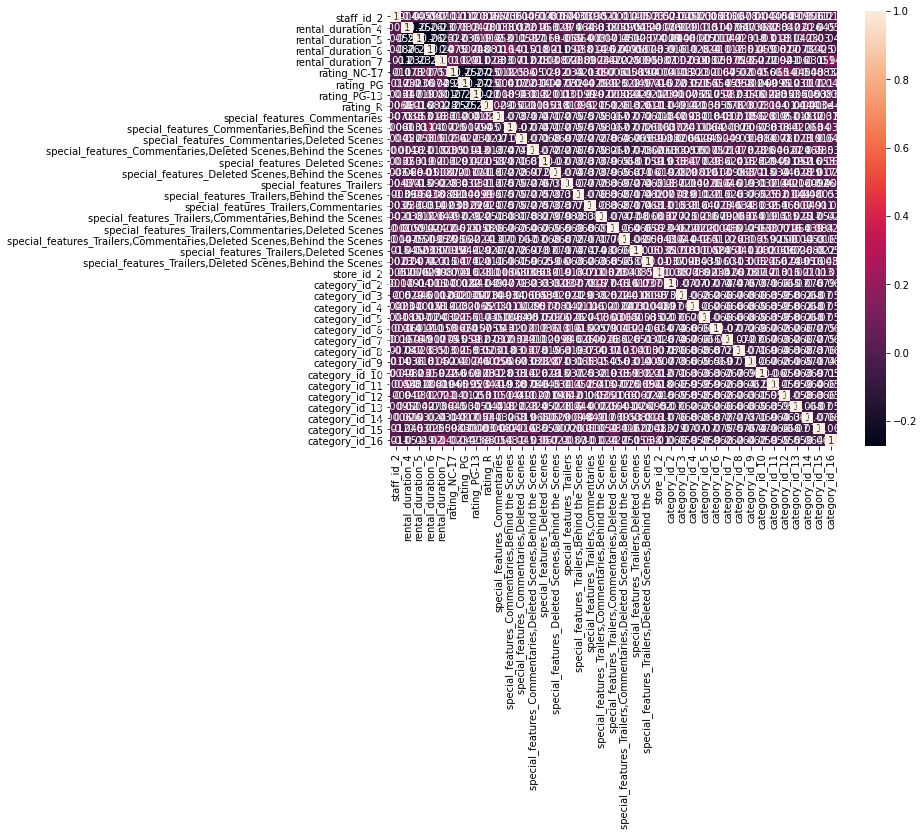

In [109]:
# Very bad visualization
corr_matrix=cat_data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

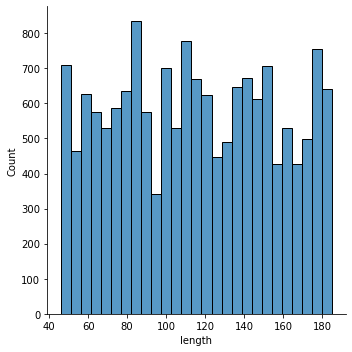

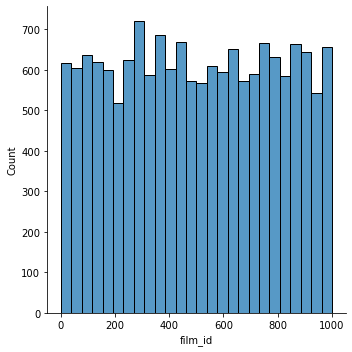

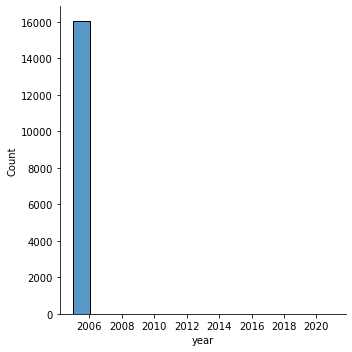

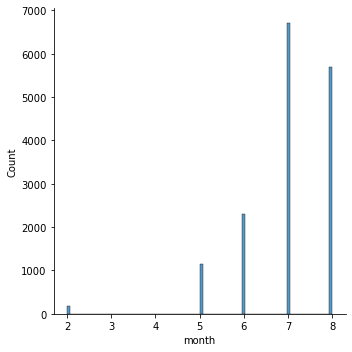

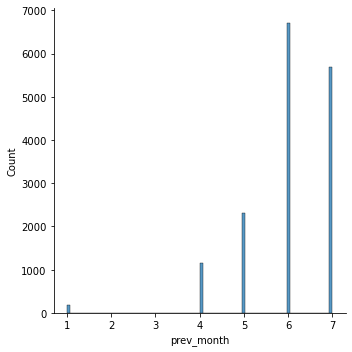

In [140]:
# Actually there is only one numerical column: length. Bc the film_id is an identificator.
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()

### 4- Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable

In [ ]:
CREATE OR REPLACE VIEW rentals_by_film AS
SELECT r.rental_id, r.rental_date 
		, f.rental_duration
		, i.film_id
FROM rental r
JOIN inventory i ON r.inventory_id = i.inventory_id
JOIN film f ON i.film_id = f.film_id
;

SELECT * FROM rentals_by_film;

CREATE OR REPLACE VIEW rental_activity AS
SELECT rental_id, film_id,
		convert(rental_date, date) AS activity_date
        , date_format(convert(rental_date, date), '%m') AS activity_month
        , date_format(convert(rental_date, date), '%y') AS activity_year
FROM rentals_by_film
;

SELECT * FROM rental_activity;

CREATE OR REPLACE VIEW monthly_active_films AS
SELECT film_id, activity_year, activity_month, 'True' AS rented_film
FROM rental_activity
GROUP BY film_id, activity_year, activity_month
ORDER BY film_id, activity_year, activity_month
;

SELECT * FROM monthly_active_films;

# From here stop working bc the lag function just work for the first row and not for each film_id
# Another issue is that it only gets te previous line and doesn't analyze if the previous line is actually the previous month
CREATE OR REPLACE VIEW monthly_active_films2 AS
SELECT film_id
		, activity_year
		, activity_month
		, rented_film
        , lag(rented_film) OVER(ORDER BY film_id, activity_year, activity_month) AS rented_last_month
FROM monthly_active_films
ORDER BY film_id
;

SELECT * FROM monthly_active_films2;

# The final information would be:
CREATE OR REPLACE VIEW view AS
SELECT film_id
		, activity_year
		, activity_month
        , rented_last_month
FROM monthly_active_films2
ORDER BY film_id
;

SELECT * FROM view;

Trying to get the same results using python instead

In [120]:
# Getting year & month
data['year'] = data['rental_date'].dt.year
data['month'] = data['rental_date'].dt.month

# Creating the key column
data['key'] = data['film_id'].astype(str) + '-' + data['year'].astype(str) + '-' +  data['month'].astype(str)

# Creating the columns previous month + previous key
data['prev_month'] = data['rental_date'].dt.month - 1
data['prev_key'] = data['film_id'].astype(str) + '-' + data['year'].astype(str) + '-' +  data['prev_month'].astype(str)
data.head()

,rental_date,staff_id,rental_duration,rental_rate,length,rating,special_features,film_id,store_id,category_id,year,month
rental_id,,,,,,,,,,,,
4863,2005-07-08 19:03:15,2,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1,6,2005,7
11433,2005-08-02 20:13:10,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1,6,2005,8
14714,2005-08-21 21:27:43,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1,6,2005,8
16050,2021-06-26 13:39:06,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1,6,2021,6
972,2005-05-30 20:21:07,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1,6,2005,5


In [136]:
# Creating a list with unique values containing film_id + previous month -> comparison base to check if the film was rented last month
prev_key_lst = np.unique(data['prev_key'])

# Now checking row by row if the film was rented last month and returning True or False to create our target column
rntd_last_month = []

for i in data['key']:
    if i in prev_key_lst:
        rntd_last_month.append('True')
    else:
        rntd_last_month.append('False')
        
data['rntd_last_month'] = rntd_last_month
data.head()

,rental_date,staff_id,rental_duration,rental_rate,length,rating,special_features,film_id,store_id,category_id,year,month,key,prev_month,prev_key,rntd_last_month
rental_id,,,,,,,,,,,,,,,,
4863,2005-07-08 19:03:15,2,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1,6,2005,7,1-2005-7,6,1-2005-6,True
11433,2005-08-02 20:13:10,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1,6,2005,8,1-2005-8,7,1-2005-7,False
14714,2005-08-21 21:27:43,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1,6,2005,8,1-2005-8,7,1-2005-7,False
16050,2021-06-26 13:39:06,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1,6,2021,6,1-2021-6,5,1-2021-5,False
972,2005-05-30 20:21:07,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1,6,2005,5,1-2005-5,4,1-2005-4,True


In [156]:
data['rntd_last_month'].value_counts()

True     10176
False     5869
Name: rntd_last_month, dtype: int64

### 5- Create a logistic regression model to predict this variable from the cleaned data

In [161]:
# when running the classification I got an error bc of the datetime column, so I'm droping it (and few more things...)
data2 = data.drop(['rental_date', 'year', 'month', 'key', 'prev_month', 'prev_key', 'film_id'], axis=1)
data2.head()

,staff_id,rental_duration,rental_rate,length,rating,special_features,store_id,category_id,rntd_last_month
rental_id,,,,,,,,,
4863,2,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,6,True
11433,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,6,False
14714,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,6,False
16050,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,6,False
972,1,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,6,True


In [162]:
y = data2['rntd_last_month']
X = data2.drop('rntd_last_month', axis=1)

In [163]:
# watch out! rookie mistake: DONNUT dummify the target variable
X = pd.get_dummies(X)
X

,length,staff_id_1,staff_id_2,rental_duration_3,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rental_rate_0.99,rental_rate_2.99,...,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
rental_id,,,,,,,,,,,,,,,,,,,,,
4863,86,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11433,86,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
14714,86,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16050,86,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
972,86,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,50,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1493,50,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6712,50,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [165]:
classification = LogisticRegression(random_state=42, multi_class='multinomial', max_iter=500) # max_iter
classification.fit(X_train, y_train)
# here the model does not converge, to solve it you can scale the data or increase the max_iter parameter
# the first option will save on processing power.

LogisticRegression(max_iter=500, multi_class='multinomial', random_state=42)

### 6- Evaluate the results (calculate the score of the model)

In [166]:
classification.score(X_test, y_test)

0.6285447179806793

In [167]:
predictions = classification.predict(X_test)

pd.Series(predictions).value_counts()
# I don't understand why I just got 'True' in my results

True    3209
dtype: int64

In [168]:
y_test.value_counts()

True     2017
False    1192
Name: rntd_last_month, dtype: int64

In [169]:
confusion_matrix(y_test, predictions)
# I don't understand why I got the first column fully blank

array([[   0, 1192],
       [   0, 2017]], dtype=int64)

<AxesSubplot:>

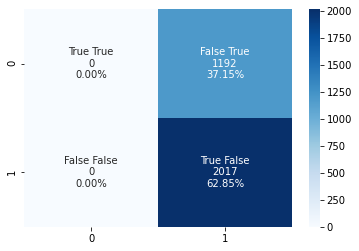

In [170]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True True', 'False True',
               'False False', 'True False']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
# I don't understand what is happening on the next line
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

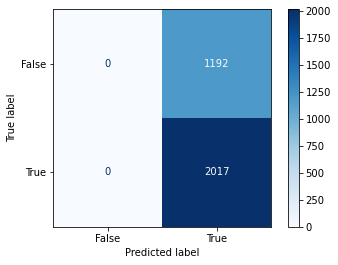

In [171]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()